In [1]:
from keras.preprocessing.image  import ImageDataGenerator, img_to_array, load_img 
from keras.models  import Sequential
from keras.layers  import Dropout,  Flatten,  Dense, GlobalAveragePooling2D, Input
from keras.applications import InceptionV3
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical 
import time
import os
import numpy as np 
import math
import  matplotlib.pyplot  as  plt

img_width = 299
img_height = 299
batch_size = 64 
epochs = 90

nb_train = 4000
nb_validation = 1200
nb_test = 1200
nb_classes = 4
nb_FC = 1024
channels_image = 3

class_mode = 'categorical'
train_dir  =  "balanced_dataset/train"
validation_dir = "balanced_dataset/validation" 
test_dir  =  "balanced_dataset/test" 


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications import Xception
#Load Pretrained model
conv_base = Xception(include_top=False, 
                     weights='imagenet', 
                     input_shape = (img_width, img_height, channels_image)) 


83689472/83683744 [==============================] - 6s 0us/step


In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [6]:
#Extracción de características del modelo Preentrenado y nuestro dataset
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

#Tamaño de salida de la última capa convoluciónal del modelo preentrenado
#lo vemos en el conv_base.summary()
out_x = 10
out_y = 10
conv_len = 2048

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, out_x, out_x, conv_len))
    labels = to_categorical(np.zeros(shape=(sample_count)),nb_classes) #INDICAR NUMERO DE CLASES
    generator = datagen.flow_from_directory(
        directory,
        target_size = (img_height, img_width),
        batch_size = batch_size,
        #classes = 4,
        class_mode = 'categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) ##Asociamos al modelo preentrenado
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

#Train: 1000 muestras x clase, con 4 clases, 1000 x 4 = 4000
train_features, train_labels = extract_features(train_dir, nb_train)
#validation 500 muestras x clase con 4 clases, 300 x 4 = 1200
validation_features, validation_labels = extract_features(validation_dir, nb_validation) 
#test 500 muestras x clase con 4 clases, 300 x 4 = 1200
test_features, test_labels = extract_features(test_dir, nb_test)


Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [8]:
np.save('Xception/Xception_FE_NS_train_1.npy',  train_features)
np.save('Xception/Xception_FE_NS_validation_1.npy',  validation_features)

In [9]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(4000, 10, 10, 2048)
(1200, 10, 10, 2048)
(1200, 10, 10, 2048)


In [10]:
#Save Features
train_data = np.load('Xception/Xception_FE_NS_train_1.npy') 
validation_data  =  np.load('Xception/Xception_FE_NS_validation_1.npy')

In [11]:
from keras.models  import Model
# add a global spatial average pooling layer
inputTensor = Input((10,10,2048)) #Use (None,None,2048) if bottlenecks vary in size    
x = GlobalAveragePooling2D()(inputTensor)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 2 classes
predictions = Dense(nb_classes, activation='softmax')(x)

# What is the correct input? Obviously not base_model.input.
model = Model(inputTensor, predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in conv_base.layers:
    layer.trainable = False

In [12]:
#Compile models
model.compile(
    optimizer = RMSprop(lr=2e-5),
    loss='categorical_crossentropy',  
    metrics=['accuracy'])


In [13]:
#Train model

history = model.fit(
    train_data, 
    train_labels,
    epochs=epochs,  
    batch_size=batch_size, 
    validation_data=(validation_data, validation_labels))


Train on 4000 samples, validate on 1200 samples
Epoch 1/90
4000/4000 [==============================] - 6s 2ms/step - loss: 1.2687 - acc: 0.4662 - val_loss: 1.1648 - val_acc: 0.5592
Epoch 2/90
4000/4000 [==============================] - 4s 1ms/step - loss: 1.0940 - acc: 0.5955 - val_loss: 1.0420 - val_acc: 0.5975
Epoch 3/90
4000/4000 [==============================] - 4s 1ms/step - loss: 0.9928 - acc: 0.6282 - val_loss: 0.9634 - val_acc: 0.6225
Epoch 4/90
4000/4000 [==============================] - 5s 1ms/step - loss: 0.9205 - acc: 0.6628 - val_loss: 0.9045 - val_acc: 0.6450
Epoch 5/90
4000/4000 [==============================] - 5s 1ms/step - loss: 0.8642 - acc: 0.6800 - val_loss: 0.8562 - val_acc: 0.6642
Epoch 6/90
4000/4000 [==============================] - 5s 1ms/step - loss: 0.8194 - acc: 0.6995 - val_loss: 0.8124 - val_acc: 0.6833
Epoch 7/90
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7820 - acc: 0.7177 - val_loss: 0.7830 - val_acc: 0.7042
Epoch 8/90
400

In [14]:
#Guardamos el modelo
# h5py 
model.save_weights('Xception/Xception_FE_NS_model_1.h5')

In [15]:
def print_graphics (history):
    #Mostramos otro tipo de grafico
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.tittle('Trainning and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    #plt.tittle('Trainning and validation loss')
    plt.legend()

    plt.show()

In [16]:
def print_evaluate_model(model, history):
    #Evaluate model
    (loss, acc) = model.evaluate(
        test_features, test_labels, 
        batch_size=batch_size, 
        verbose=0)

    print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

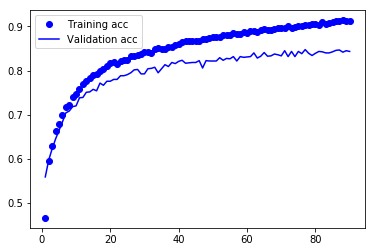

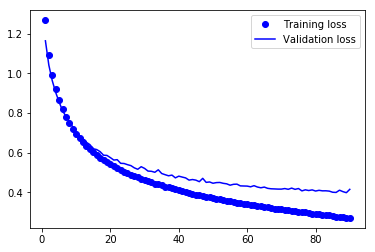

In [17]:
print_graphics (history)

In [18]:
print_evaluate_model(model, history)

acc: 82.50% - loss: 0.462230
